In [1]:
# =========================
# 0) Setup & Dependencies
# =========================
!pip -q install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


In [2]:
# =========================
# 1) Imports & Drive Mount
# =========================
import os, math, json, random, copy, csv, time
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# --------- Paths (edit the root to your preference) ----------
PROJECT_NAME = "ATML_PA4_Task1_FedSGD"
DRIVE_ROOT = f"/content/drive/MyDrive/{PROJECT_NAME}"
os.makedirs(DRIVE_ROOT, exist_ok=True)
print("Saving all outputs to:", DRIVE_ROOT)


Mounted at /content/drive
Saving all outputs to: /content/drive/MyDrive/ATML_PA4_Task1_FedSGD


In [3]:
# =========================
# 2) Reproducibility Utils
# =========================
def set_seed(seed: int = 18):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(18)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [4]:
# ==========================================
# 3) CIFAR-10: Transforms, Load, IID Split
# ==========================================
NUM_CLIENTS = 5
BATCH_SIZE = 128

# Light transforms (keep it simple for equivalence experiments)
# train_tf = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
# ])
# test_tf = transforms.Compose([
#     transforms.ToTensor(),
# ])

from torchvision import transforms

# CIFAR-10 channel-wise normalization stats
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD  = (0.2470, 0.2435, 0.2616)

# Training transforms (light aug + normalization)
train_tf = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

# Test/validation transforms (normalization only)
test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])


root_data = "/content/data"
train_set_full = datasets.CIFAR10(root=root_data, train=True, download=True, transform=train_tf)
test_set = datasets.CIFAR10(root=root_data, train=False, download=True, transform=test_tf)

N_total = len(train_set_full)
print("Total train samples:", N_total)

# ---------- IID Partition across clients ----------
indices = np.arange(N_total)
rng = np.random.default_rng(123)
rng.shuffle(indices)
client_indices = np.array_split(indices, NUM_CLIENTS)  # equal-ish IID chunks

client_subsets = [Subset(train_set_full, idxs.tolist()) for idxs in client_indices]
client_loaders = [
    DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    for ds in client_subsets
]

# Centralized union loader (same underlying dataset)
central_loader = DataLoader(train_set_full, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
# test_loader = DataLoader(test_set, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)
# Also make your test loader consistent:
test_loader = DataLoader(
    test_set, batch_size=256, shuffle=False,
    num_workers=2, pin_memory=True,
    persistent_workers=True, prefetch_factor=2
)

client_sizes = [len(ds) for ds in client_subsets]
print("Client sizes:", client_sizes, "sum:", sum(client_sizes))


100%|██████████| 170M/170M [00:24<00:00, 6.83MB/s]


Total train samples: 50000
Client sizes: [10000, 10000, 10000, 10000, 10000] sum: 50000


In [5]:
# =========================
# 4) Model Definition (CNN)
# =========================
class SmallCIFAR10CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # Block 1
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        # Block 2
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        # Classifier
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # 32x32 -> 16x16
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # 16x16 -> 8x8
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


# class SmallCIFAR10CNN(nn.Module):
#     def __init__(self, num_classes=10):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
#         self.gn1 = nn.GroupNorm(num_groups=8, num_channels=32)
#         self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
#         self.gn2 = nn.GroupNorm(num_groups=8, num_channels=64)
#         self.pool = nn.MaxPool2d(2,2)
#         self.fc1 = nn.Linear(64 * 8 * 8, 128)
#         self.fc2 = nn.Linear(128, num_classes)

#     def forward(self, x):
#         x = self.pool(F.relu(self.gn1(self.conv1(x))))
#         x = self.pool(F.relu(self.gn2(self.conv2(x))))
#         x = x.view(x.size(0), -1)
#         x = F.relu(self.fc1(x))
#         return self.fc2(x)



def init_model():
    m = SmallCIFAR10CNN()
    return m

# Utility: deep copy model with identical weights
def clone_model(model: nn.Module):
    new_m = init_model()
    new_m.load_state_dict(copy.deepcopy(model.state_dict()))
    return new_m


In [6]:
# =================================
# 5) Evaluation & Helper Functions
# =================================
@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader, device):
    model.eval()
    correct, total, loss_sum = 0, 0, 0.0
    ce = nn.CrossEntropyLoss(reduction='mean')
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = ce(logits, yb)
        loss_sum += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += xb.size(0)
    return loss_sum / total, correct / total

def flatten_params(model: nn.Module):
    return torch.cat([p.detach().view(-1).cpu() for p in model.parameters()])

def param_l2_diff(model_a: nn.Module, model_b: nn.Module):
    va = flatten_params(model_a)
    vb = flatten_params(model_b)
    return torch.norm(va - vb, p=2).item()

def zero_like_params(model: nn.Module):
    return [torch.zeros_like(p, device=device) for p in model.parameters()]

import torch.nn as nn

def extract_bn_buffers(model):
    """Return ordered lists of BN buffers for running_mean, running_var, num_batches_tracked."""
    rms, rvs, nbts = [], [], []
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            rms.append(m.running_mean.detach().clone())
            rvs.append(m.running_var.detach().clone())
            # num_batches_tracked is a 0-dim tensor
            nbts.append(m.num_batches_tracked.detach().clone())
    return rms, rvs, nbts

def set_bn_buffers(model, rms, rvs, nbts):
    """Assign the aggregated BN buffers back into the model."""
    i = 0
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.running_mean.copy_(rms[i])
            m.running_var.copy_(rvs[i])
            m.num_batches_tracked.copy_(nbts[i])
            i += 1



In [8]:
# ================================================================
# Task 2 — FedAvg implementation + experiments for K and f
# Reuses Task-1 code: model/init_model, loaders, evaluate, device, DRIVE_ROOT
# ================================================================

import os, time, math, copy, csv, random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# ---------- Helpers reused/extended ----------
def flatten_params(model: nn.Module):
    return torch.cat([p.detach().view(-1).cpu() for p in model.parameters()])

def l2_param_distance(a: nn.Module, b: nn.Module):
    return torch.norm(flatten_params(a) - flatten_params(b), p=2).item()

def model_num_bytes(model: nn.Module):
    # Params + buffers (e.g., running stats) for comm accounting
    n_bytes = 0
    for p in model.parameters():
        n_bytes += p.numel() * p.element_size()
    for b in model.buffers():
        n_bytes += b.numel() * b.element_size()
    return n_bytes

# --- BN buffer aggregation (safe if you use BatchNorm; no-op for GroupNorm) ---
def extract_bn_buffers(model):
    rms, rvs, nbts = [], [], []
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            rms.append(m.running_mean.detach().clone())
            rvs.append(m.running_var.detach().clone())
            nbts.append(m.num_batches_tracked.detach().clone())
    return rms, rvs, nbts

def set_bn_buffers(model, rms, rvs, nbts):
    i = 0
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.running_mean.copy_(rms[i])
            m.running_var.copy_(rvs[i])
            m.num_batches_tracked.copy_(nbts[i])
            i += 1

def aggregate_bn_buffers(participating_bn, weights):
    """participating_bn: list of (rms, rvs, nbts); weights: same length, sum to 1"""
    if len(participating_bn) == 0 or len(participating_bn[0][0]) == 0:
        return None
    num_bn = len(participating_bn[0][0])
    agg_rms = [torch.zeros_like(participating_bn[0][0][k]) for k in range(num_bn)]
    agg_rvs = [torch.zeros_like(participating_bn[0][1][k]) for k in range(num_bn)]
    # Initialize agg_nbts as float to avoid type casting issues during aggregation
    agg_nbts = [torch.zeros_like(participating_bn[0][2][k], dtype=torch.float32) for k in range(num_bn)]

    for (rms, rvs, nbts), w in zip(participating_bn, weights):
        for k in range(num_bn):
            agg_rms[k] += w * rms[k]
            agg_rvs[k] += w * rvs[k]
            # Aggregate num_batches_tracked as float
            agg_nbts[k] += w * nbts[k].float()
    # num_batches_tracked must be integer, convert back to long after aggregation
    agg_nbts = [x.round().to(dtype=torch.long) for x in agg_nbts]

    return agg_rms, agg_rvs, agg_nbts

# ---------- One FedAvg communication round ----------
@torch.no_grad()
def copy_model(src: nn.Module, dst: nn.Module):
    dst.load_state_dict(copy.deepcopy(src.state_dict()))

def client_local_train(model, loader, epochs, lr, momentum, weight_decay, device):
    """Standard local SGD on client's data for 'epochs'."""
    model.train()
    opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    ce = nn.CrossEntropyLoss()
    for _ in range(epochs):
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = ce(logits, yb)
            loss.backward()
            opt.step()

def fedavg_round(global_model,
                 client_loaders,
                 client_sizes,
                 K=5,
                 client_fraction=1.0,
                 lr=0.01,
                 momentum=0.9,
                 weight_decay=5e-4,
                 device="cuda"):
    """
    Returns:
      new_global_model, drift_value, comm_stats (bytes_down, bytes_up), participating_ids
    """
    M = len(client_loaders)
    n_participate = max(1, int(round(client_fraction * M)))
    client_ids = list(range(M))
    random.shuffle(client_ids)
    selected = client_ids[:n_participate]

    # Bytes: send global model to each selected client; receive updated model back
    bytes_model = model_num_bytes(global_model)
    bytes_down = bytes_model * n_participate
    bytes_up   = bytes_model * n_participate

    # Save θ_g^t
    theta_g_t = copy.deepcopy(global_model.state_dict())

    # Per-client train
    client_models = []
    client_bn_bufs = []
    for i in selected:
        local_model = copy.deepcopy(global_model).to(device)
        client_local_train(local_model, client_loaders[i], epochs=K,
                           lr=lr, momentum=momentum, weight_decay=weight_decay, device=device)
        client_models.append((i, local_model))
        # collect BN buffers if any
        client_bn_bufs.append(extract_bn_buffers(local_model))

    # Weighted average of client weights (Ni / N_selected)
    N_selected = sum(client_sizes[i] for i in selected)
    new_state = copy.deepcopy(global_model.state_dict())
    for k in new_state.keys():
        # Ensure that num_batches_tracked is handled correctly during aggregation
        if 'num_batches_tracked' in k:
            new_state[k] = torch.zeros_like(new_state[k], dtype=torch.float)
        else:
            new_state[k].zero_()


    for (i, local_model) in client_models:
        wi = client_sizes[i] / N_selected
        local_sd = local_model.state_dict()
        for k in new_state.keys():
            if 'num_batches_tracked' in k:
                new_state[k] += wi * local_sd[k].float()
            else:
                new_state[k] += wi * local_sd[k]

    # Convert num_batches_tracked back to long after aggregation
    for k in new_state.keys():
        if 'num_batches_tracked' in k:
             new_state[k] = new_state[k].round().to(dtype=torch.long)

    # Update global
    global_model.load_state_dict(new_state)

    # Aggregate BN buffers for evaluation consistency (if BN exists)
    weights = [(client_sizes[i] / N_selected) for i, _ in client_models]
    agg = aggregate_bn_buffers(client_bn_bufs, weights)
    if agg is not None:
        set_bn_buffers(global_model, *agg)


    # Drift: average L2 ||θ_i^K − θ_g^t|| over selected clients
    # Compute using flattened vectors for stability
    with torch.no_grad():
        # reconstruct θ_g^t as a model to reuse l2 helper
        model_g_t = copy.deepcopy(global_model).to(device)
        model_g_t.load_state_dict(theta_g_t)
        drift_vals = []
        for _, local_model in client_models:
            drift_vals.append(l2_param_distance(local_model, model_g_t))
        drift = float(np.mean(drift_vals)) if drift_vals else 0.0

    return global_model, drift, (bytes_down, bytes_up), selected

In [10]:
# ================================================================
# Task 3 — Dirichlet(α) non-IID partitioning + FedAvg runs
# Saves per-client class distributions and training curves to Drive
# ================================================================

import os, json, math, copy, time, random
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Subset, DataLoader
from torchvision import datasets

# Where to save Task 3 artifacts
TASK3_DIR = os.path.join(DRIVE_ROOT, "task3_nonIID_dirichlet")
os.makedirs(TASK3_DIR, exist_ok=True)

# Re-load CIFAR-10 train set with *training* transform (same as earlier)
root_data = "/content/data"
train_set_full = datasets.CIFAR10(root=root_data, train=True, download=True, transform=train_tf)

NUM_CLIENTS = 5  # fixed for this assignment

def dirichlet_split_cifar10(train_set, num_clients, alpha, seed=1234, min_size_per_client=10):
    """
    Returns:
      client_indices: list[list[int]] indices per client
      class_hist: list[np.array shape (10,)] class counts per client
    """
    rng = np.random.default_rng(seed)
    y = np.array(train_set.targets)  # CIFAR-10 labels
    num_classes = 10

    # collect indices for each class
    class_indices = [np.where(y == c)[0] for c in range(num_classes)]
    for c in range(num_classes):
        rng.shuffle(class_indices[c])

    # draw class proportions from Dirichlet for each class
    # alpha can be a scalar; use symmetric Dir
    client_indices = [[] for _ in range(num_clients)]
    for c in range(num_classes):
        n_c = len(class_indices[c])
        if alpha >= 50:  # treat as IID split
            # uniform proportions (avoid floating point artifacts)
            props = np.ones(num_clients) / num_clients
        else:
            props = rng.dirichlet(alpha * np.ones(num_clients))
        # turn proportions into counts that sum to n_c
        counts = np.floor(props * n_c).astype(int)
        # adjust rounding to hit exact n_c
        while counts.sum() < n_c:
            counts[rng.integers(0, num_clients)] += 1
        while counts.sum() > n_c:
            j = rng.integers(0, num_clients)
            if counts[j] > 0:
                counts[j] -= 1

        start = 0
        for i in range(num_clients):
            idxs = class_indices[c][start:start+counts[i]]
            client_indices[i].extend(idxs.tolist())
            start += counts[i]

    # ensure each client has at least min_size_per_client samples
    # (very small alpha can cause empties; this guard is light)
    for i in range(num_clients):
        if len(client_indices[i]) < min_size_per_client:
            # simple fix: borrow from the largest client
            sizes = [len(ci) for ci in client_indices]
            donor = int(np.argmax(sizes))
            need = min_size_per_client - len(client_indices[i])
            take = client_indices[donor][:need]
            client_indices[i].extend(take)
            client_indices[donor] = client_indices[donor][need:]

    # shuffle per client for loader order
    for i in range(num_clients):
        rng.shuffle(client_indices[i])

    # class histogram per client
    class_hist = []
    for i in range(num_clients):
        labels_i = y[np.array(client_indices[i])]
        hist = np.bincount(labels_i, minlength=num_classes)
        class_hist.append(hist)

    return client_indices, class_hist

# def build_client_loaders_from_indices(train_set, client_indices, batch_size=64, num_workers=2):
#     client_subsets = [Subset(train_set, idxs) for idxs in client_indices]
#     client_loaders = [
#         DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
#         for ds in client_subsets
#     ]
#     client_sizes = [len(ds) for ds in client_subsets]
#     return client_loaders, client_sizes


import torch.multiprocessing as mp
try:
    mp.set_start_method("spawn", force=True)
except RuntimeError:
    pass  # already set

def build_client_loaders_from_indices(train_set, client_indices, batch_size=64, num_workers=2):
    client_subsets = [Subset(train_set, idxs) for idxs in client_indices]
    client_loaders = [
        DataLoader(
            ds, batch_size=batch_size, shuffle=True,
            num_workers=num_workers, pin_memory=True,
            persistent_workers=True, prefetch_factor=2
        )
        for ds in client_subsets
    ]
    client_sizes = [len(ds) for ds in client_subsets]
    return client_loaders, client_sizes





def save_class_distribution(alpha, class_hist, client_sizes, out_dir):
    df_rows = []
    for i, hist in enumerate(class_hist):
        row = {"client": i, "total": int(client_sizes[i])}
        for c in range(10):
            row[f"class_{c}"] = int(hist[c])
            row[f"pct_{c}"] = float(hist[c]) / max(1, client_sizes[i])
        df_rows.append(row)
    df = pd.DataFrame(df_rows)
    csv_path = os.path.join(out_dir, f"class_distribution_alpha_{alpha}.csv")
    df.to_csv(csv_path, index=False)

    json_path = os.path.join(out_dir, f"class_distribution_alpha_{alpha}.json")
    with open(json_path, "w") as f:
        json.dump(df_rows, f, indent=2)

    print(f"[α={alpha}] Saved per-client class distribution to:")
    print(" -", csv_path)
    print(" -", json_path)
    return df


# Task 4

Subtask 4.1 - FedProxy


In [12]:
# ================================================================
# Task 4.1 — FedProx implementation + experiments
# Requirements:
#   - From previous tasks, we assume you already have:
#       init_model, evaluate, device, DRIVE_ROOT
#       dirichlet_split_cifar10, build_client_loaders_from_indices, save_class_distribution
#       (from Task 3), and CIFAR-10 train/test transforms & test_loader.
# ================================================================

import os, time, math, copy, csv, random, json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

TASK41_DIR = os.path.join(DRIVE_ROOT, "task4_1_fedprox")
os.makedirs(TASK41_DIR, exist_ok=True)

# ---------- BN buffer helpers (safe if using GroupNorm; no-op in practice) ----------
def extract_bn_buffers(model):
    rms, rvs, nbts = [], [], []
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            rms.append(m.running_mean.detach().clone())
            rvs.append(m.running_var.detach().clone())
            nbts.append(m.num_batches_tracked.detach().clone())
    return rms, rvs, nbts

def set_bn_buffers(model, rms, rvs, nbts):
    i = 0
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.running_mean.copy_(rms[i])
            m.running_var.copy_(rvs[i])
            m.num_batches_tracked.copy_(nbts[i])
            i += 1

def aggregate_bn_buffers(participating_bn, weights):
    if len(participating_bn) == 0 or len(participating_bn[0][0]) == 0:
        return None
    num_bn = len(participating_bn[0][0])
    agg_rms = [torch.zeros_like(participating_bn[0][0][k]) for k in range(num_bn)]
    agg_rvs = [torch.zeros_like(participating_bn[0][1][k]) for k in range(num_bn)]
    agg_nbts = [torch.zeros_like(participating_bn[0][2][k], dtype=torch.float32) for k in range(num_bn)]
    for (rms, rvs, nbts), w in zip(participating_bn, weights):
        for k in range(num_bn):
            agg_rms[k] += w * rms[k]
            agg_rvs[k] += w * rvs[k]
            agg_nbts[k] += w * nbts[k].float()
    agg_nbts = [x.round().to(dtype=torch.long) for x in agg_nbts]
    return agg_rms, agg_rvs, agg_nbts

# ---------- Utilities ----------
def flatten_params(model: nn.Module):
    return torch.cat([p.detach().view(-1).cpu() for p in model.parameters()])

def l2_param_distance(a: nn.Module, b: nn.Module):
    return torch.norm(flatten_params(a) - flatten_params(b), p=2).item()

def model_num_bytes(model: nn.Module):
    n_bytes = 0
    for p in model.parameters():
        n_bytes += p.numel() * p.element_size()
    for b in model.buffers():
        n_bytes += b.numel() * b.element_size()
    return n_bytes


In [13]:
# ================================================================
# FedProx client update: add proximal term (mu/2) * ||theta - theta_g||^2
# Efficient & clear: capture a frozen copy of global params (same shapes, same order)
# ================================================================
def capture_param_tensors(model: nn.Module):
    """Return a list of detached param tensors (global snapshot) in parameter order."""
    return [p.detach().clone() for p in model.parameters()]

def prox_term_l2(model: nn.Module, global_params_snapshot, mu: float, device):
    """Compute (mu/2) * sum ||p - p0||^2 across all parameters."""
    prox = 0.0
    for (p, p0) in zip(model.parameters(), global_params_snapshot):
        prox = prox + (p - p0.to(device)).pow(2).sum()
    return 0.5 * mu * prox

def client_local_train_prox(model, loader, epochs, lr, momentum, weight_decay, device,
                            mu, global_params_snapshot):
    model.train()
    opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    ce = nn.CrossEntropyLoss()
    for _ in range(epochs):
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad(set_to_none=True)
            logits = model(xb)
            data_loss = ce(logits, yb)
            prox_loss = prox_term_l2(model, global_params_snapshot, mu, device)
            loss = data_loss + prox_loss
            loss.backward()
            opt.step()


In [14]:
import torch.nn as nn

# ================================================================
# One FedProx round (server and clients)
#   - Fixed participation fraction f (usually 1.0 for Task 4.1)
#   - Weighted average of client models
#   - BN buffers aggregation (if any BN exists)
# Logs: drift (avg L2 between local models and theta_g^t), comm bytes
# ================================================================
@torch.no_grad()
def copy_model(src: nn.Module, dst: nn.Module):
    dst.load_state_dict(copy.deepcopy(src.state_dict()))

def fedprox_round(global_model,
                  client_loaders,
                  client_sizes,
                  K=3,
                  client_fraction=1.0,
                  lr=0.01,
                  momentum=0.9,
                  weight_decay=5e-4,
                  mu=0.01,
                  device="cuda"):
    M = len(client_loaders)
    n_participate = max(1, int(round(client_fraction * M)))
    client_ids = list(range(M))
    random.shuffle(client_ids)
    selected = client_ids[:n_participate]

    bytes_model = model_num_bytes(global_model)
    bytes_down = bytes_model * n_participate
    bytes_up   = bytes_model * n_participate

    # snapshot global weights for proximal term
    global_snapshot = capture_param_tensors(global_model)

    # keep a copy of theta_g^t to compute drift later
    theta_g_t = copy.deepcopy(global_model.state_dict())

    # local training
    client_models = []
    client_bn_bufs = []
    for i in selected:
        local_model = copy.deepcopy(global_model).to(device)
        client_local_train_prox(local_model, client_loaders[i], epochs=K,
                                lr=lr, momentum=momentum, weight_decay=weight_decay,
                                device=device, mu=mu, global_params_snapshot=global_snapshot)
        client_models.append((i, local_model))
        client_bn_bufs.append(extract_bn_buffers(local_model))

    # aggregate weights (Ni / sum Ni of selected)
    N_selected = sum(client_sizes[i] for i in selected)
    new_state = copy.deepcopy(global_model.state_dict())
    for k in new_state.keys():
        # Ensure that num_batches_tracked is handled correctly during aggregation
        if 'num_batches_tracked' in k:
            new_state[k] = torch.zeros_like(new_state[k], dtype=torch.float)
        else:
            new_state[k].zero_()

    for (i, local_model) in client_models:
        wi = client_sizes[i] / N_selected
        local_sd = local_model.state_dict()
        for k in new_state.keys():
            if 'num_batches_tracked' in k:
                new_state[k] += wi * local_sd[k].float()
            else:
                new_state[k] += wi * local_sd[k]

    # Convert num_batches_tracked back to long after aggregation
    for k in new_state.keys():
        if 'num_batches_tracked' in k:
             new_state[k] = new_state[k].round().to(dtype=torch.long)

    global_model.load_state_dict(new_state)

    # aggregate BN buffers for eval stability
    weights = [(client_sizes[i] / N_selected) for i, _ in client_models]
    agg = aggregate_bn_buffers(client_bn_bufs, weights)
    if agg is not None:
        set_bn_buffers(global_model, *agg)

    # drift
    with torch.no_grad():
        model_g_t = copy.deepcopy(global_model).to(device)
        model_g_t.load_state_dict(theta_g_t)
        drift_vals = []
        for _, local_model in client_models:
            drift_vals.append(l2_param_distance(local_model, model_g_t))
        drift = float(np.mean(drift_vals)) if drift_vals else 0.0

    return global_model, drift, (bytes_down, bytes_up), selected

In [15]:
# ================================================================
# Runner for FedProx experiments (mirrors Task-2's runner)
# ================================================================
def run_fedprox_experiment(config, tag, save_dir,
                           client_loaders, client_sizes,
                           test_loader, device):
    """
    config: dict(
      rounds, K, f, lr, momentum, weight_decay, mu, seeds, eval_every
    )
    """
    os.makedirs(save_dir, exist_ok=True)
    csv_path = os.path.join(save_dir, f"{tag}_logs.csv")
    model_path = os.path.join(save_dir, f"{tag}_final_model.pt")

    logs = []
    for seed in config["seeds"]:
        random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

        global_model = init_model().to(device)
        # reuse initial weights for fair comparison if saved earlier
        init_path = os.path.join(DRIVE_ROOT, "init_weights_task1.pt")
        if os.path.exists(init_path):
            global_model.load_state_dict(torch.load(init_path, map_location=device))

        bytes_total_down, bytes_total_up = 0, 0

        R = config["rounds"]
        K = config["K"]
        f = config["f"]
        lr = config["lr"]
        momentum = config["momentum"]
        wd = config["weight_decay"]
        mu = config["mu"]
        eval_every = config.get("eval_every", 1)

        for t in range(1, R + 1):
            t0 = time.time()
            global_model, drift, (bytes_down, bytes_up), selected = fedprox_round(
                global_model,
                client_loaders=client_loaders,
                client_sizes=client_sizes,
                K=K, client_fraction=f,
                lr=lr, momentum=momentum, weight_decay=wd,
                mu=mu, device=device
            )
            bytes_total_down += bytes_down
            bytes_total_up   += bytes_up

            # eval
            if (t % eval_every) == 0 or (t == R):
                test_loss, test_acc = evaluate(global_model, test_loader, device)
            else:
                test_loss, test_acc = float("nan"), float("nan")

            row = {
                "seed": seed, "round": t,
                "K": K, "f": f, "mu": mu,
                "test_loss": test_loss, "test_acc": test_acc,
                "drift_l2": drift,
                "bytes_down": bytes_down, "bytes_up": bytes_up,
                "cum_bytes_down": bytes_total_down, "cum_bytes_up": bytes_total_up,
                "time_sec": time.time() - t0,
                "participating": len(selected),
            }
            logs.append(row)
            if not math.isnan(test_acc):
                print(f"[{tag}] seed={seed} round={t:02d}  acc={test_acc:.4f}  drift={drift:.2f}  mu={mu}")

        torch.save(global_model.state_dict(), model_path)

    # write CSV
    if logs:
        with open(csv_path, "w", newline="") as f:
            writer = csv.DictWriter(f, fieldnames=list(logs[0].keys()))
            writer.writeheader()
            writer.writerows(logs)
    print("Saved:", csv_path)
    print("Saved model:", model_path)
    return logs, csv_path, model_path


In [16]:
# ================================================================
# 4.1-A) FedProx across Dirichlet α values (fixed µ)
#   - Also saves per-client class distributions like Task 3
# ================================================================
from torchvision import datasets

root_data = "/content/data"
from torchvision import transforms
# (Re)use your normalized transforms defined earlier: train_tf, test_tf
train_set_full = datasets.CIFAR10(root=root_data, train=True, download=True, transform=train_tf)

def run_task41_fedprox_alpha_sweep(
    alphas=(1.0, 0.2, 0.05, 100),
    K=3,
    rounds=30,
    lr=0.05, momentum=0.9, weight_decay=5e-4,
    mu=0.01,                 # fixed µ for this sweep
    seeds=(0,),
    partition_seed=404,      # controls the Dirichlet split
    batch_size=64,
):
    results = {}
    for alpha in alphas:
        print("\n" + "="*72)
        print(f"[FedProx α-sweep] Building Dirichlet split α={alpha} (seed={partition_seed})")
        print("="*72)

        split_dir = os.path.join(TASK41_DIR, f"alpha_{alpha}_mu_{mu}")
        os.makedirs(split_dir, exist_ok=True)

        client_idxs, class_hist = dirichlet_split_cifar10(
            train_set_full, num_clients=5, alpha=alpha, seed=partition_seed
        )
        client_loaders_local, client_sizes_local = build_client_loaders_from_indices(
            train_set_full, client_idxs, batch_size=batch_size, num_workers=2
        )

        # save & show which classes each client got
        dist_df = save_class_distribution(alpha, class_hist, client_sizes_local, split_dir)
        display(dist_df)

        cfg = {
            "rounds": rounds, "K": K, "f": 1.0,
            "lr": lr, "momentum": momentum, "weight_decay": weight_decay,
            "mu": mu,
            "seeds": list(seeds), "eval_every": 1,
        }
        tag = f"fedprox_alpha_{alpha}_K{K}_mu{mu}"
        logs, csv_path, model_path = run_fedprox_experiment(
            cfg, tag, save_dir=split_dir,
            client_loaders=client_loaders_local, client_sizes=client_sizes_local,
            test_loader=test_loader, device=device
        )
        results[alpha] = (logs, csv_path, model_path, split_dir)

    # Plot: Accuracy vs Rounds across α
    import matplotlib.pyplot as plt
    plt.figure(figsize=(7.6,5.2))
    for alpha in alphas:
        df = pd.DataFrame(results[alpha][0])
        acc_curve = df.groupby("round")["test_acc"].mean()
        plt.plot(acc_curve.index, acc_curve.values, label=f"α={alpha}")
    plt.xlabel("Round"); plt.ylabel("Global Test Accuracy")
    plt.title(f"FedProx (µ={mu}): Accuracy vs Rounds across Dirichlet α (K={K})")
    plt.grid(True, alpha=0.3); plt.legend()
    fig_acc = os.path.join(TASK41_DIR, f"fedprox_alpha_sweep_acc_mu{mu}_K{K}.png")
    plt.savefig(fig_acc, dpi=150, bbox_inches='tight')
    plt.show()

    # Optional: Drift vs Rounds
    plt.figure(figsize=(7.6,5.2))
    for alpha in alphas:
        df = pd.DataFrame(results[alpha][0])
        drift_curve = df.groupby("round")["drift_l2"].mean()
        plt.plot(drift_curve.index, drift_curve.values, label=f"α={alpha}")
    plt.xlabel("Round"); plt.ylabel("Avg Drift ‖θ_i^K − θ_g^t‖₂")
    plt.title(f"FedProx (µ={mu}): Drift vs Rounds across Dirichlet α (K={K})")
    plt.grid(True, alpha=0.3); plt.legend()
    fig_drift = os.path.join(TASK41_DIR, f"fedprox_alpha_sweep_drift_mu{mu}_K{K}.png")
    plt.savefig(fig_drift, dpi=150, bbox_inches='tight')
    plt.show()

    print("Saved α-sweep figures to:")
    print(" -", fig_acc)
    print(" -", fig_drift)
    return results


In [17]:
# ================================================================
# 4.1-B) µ sensitivity at a fixed α (pick α=0.2 for clear heterogeneity)
#   - Run for µ ∈ {0.005, 0.01, 0.05}
# ================================================================
def run_task41_mu_sweep(
    alpha_fixed=0.2,
    mus=(0.005, 0.01, 0.05),
    K=3,
    rounds=30,
    lr=0.05, momentum=0.9, weight_decay=5e-4,
    seeds=(0,),
    partition_seed=404,
    batch_size=64,
):
    results = {}
    print("\n" + "="*72)
    print(f"[FedProx µ-sweep] Building Dirichlet split α={alpha_fixed} (seed={partition_seed})")
    print("="*72)

    base_dir = os.path.join(TASK41_DIR, f"mu_sweep_alpha_{alpha_fixed}")
    os.makedirs(base_dir, exist_ok=True)

    # Build once and reuse the same split for fairness across µ
    client_idxs, class_hist = dirichlet_split_cifar10(
        train_set_full, num_clients=5, alpha=alpha_fixed, seed=partition_seed
    )
    client_loaders_local, client_sizes_local = build_client_loaders_from_indices(
        train_set_full, client_idxs, batch_size=batch_size, num_workers=2
    )
    # Save once
    dist_df = save_class_distribution(alpha_fixed, class_hist, client_sizes_local, base_dir)
    display(dist_df)

    for mu in mus:
        cfg = {
            "rounds": rounds, "K": K, "f": 1.0,
            "lr": lr, "momentum": momentum, "weight_decay": weight_decay,
            "mu": mu, "seeds": list(seeds), "eval_every": 1,
        }
        tag = f"fedprox_mu_{mu}_alpha_{alpha_fixed}_K{K}"
        logs, csv_path, model_path = run_fedprox_experiment(
            cfg, tag, save_dir=base_dir,
            client_loaders=client_loaders_local, client_sizes=client_sizes_local,
            test_loader=test_loader, device=device
        )
        results[mu] = (logs, csv_path, model_path, base_dir)

    # Plot: Accuracy vs Rounds across µ
    import matplotlib.pyplot as plt
    plt.figure(figsize=(7.6,5.2))
    for mu in mus:
        df = pd.DataFrame(results[mu][0])
        acc_curve = df.groupby("round")["test_acc"].mean()
        plt.plot(acc_curve.index, acc_curve.values, label=f"µ={mu}")
    plt.xlabel("Round"); plt.ylabel("Global Test Accuracy")
    plt.title(f"FedProx µ-sweep at α={alpha_fixed} (K={K})")
    plt.grid(True, alpha=0.3); plt.legend()
    fig_acc = os.path.join(base_dir, f"fedprox_mu_sweep_acc_alpha_{alpha_fixed}_K{K}.png")
    plt.savefig(fig_acc, dpi=150, bbox_inches='tight')
    plt.show()

    # Optional: Final accuracy bar
    finals = []
    labels = []
    for mu in mus:
        df = pd.DataFrame(results[mu][0])
        last = df.sort_values(["seed","round"]).groupby("seed").tail(1)
        finals.append(last["test_acc"].mean())
        labels.append(f"µ={mu}")
    plt.figure(figsize=(6.5,4.6))
    plt.bar(labels, finals)
    plt.ylabel("Final Global Test Accuracy")
    plt.title(f"FedProx Final Accuracy (α={alpha_fixed}, K={K})")
    plt.grid(True, axis='y', alpha=0.3)
    fig_bar = os.path.join(base_dir, f"fedprox_mu_sweep_final_acc_alpha_{alpha_fixed}_K{K}.png")
    plt.savefig(fig_bar, dpi=150, bbox_inches='tight')
    plt.show()

    print("Saved µ-sweep figures to:")
    print(" -", fig_acc)
    print(" -", fig_bar)
    return results


In [19]:
# =========================
# Run Task 4.1 experiments
# =========================
# A) FedProx across α (fixed µ)
results_alpha = run_task41_fedprox_alpha_sweep(
    alphas=(1.0, 0.2, 0.05),  # IID → highly skewed
    K=3, rounds=30,
    lr=0.05, momentum=0.9, weight_decay=5e-4,
    mu=0.01,     # fixed µ for α-sweep
    seeds=(0,),  # add more seeds later if needed
    partition_seed=123, batch_size=64
)



[FedProx α-sweep] Building Dirichlet split α=1.0 (seed=123)
[α=1.0] Saved per-client class distribution to:
 - /content/drive/MyDrive/ATML_PA4_Task1_FedSGD/task4_1_fedprox/alpha_1.0_mu_0.01/class_distribution_alpha_1.0.csv
 - /content/drive/MyDrive/ATML_PA4_Task1_FedSGD/task4_1_fedprox/alpha_1.0_mu_0.01/class_distribution_alpha_1.0.json


,client,total,class_0,pct_0,class_1,pct_1,class_2,pct_2,class_3,pct_3,...,class_5,pct_5,class_6,pct_6,class_7,pct_7,class_8,pct_8,class_9,pct_9
0,0,11148,998,0.089523,137,0.012289,1467,0.131593,815,0.073107,...,1166,0.104593,2426,0.217618,1818,0.163079,354,0.031755,1072,0.096161
1,1,10190,1195,0.117272,1265,0.124141,418,0.041021,1259,0.123553,...,288,0.028263,1982,0.194504,941,0.092345,1523,0.149460,1155,0.113346
2,2,10442,994,0.095192,583,0.055832,2310,0.221222,352,0.033710,...,327,0.031316,253,0.024229,709,0.067899,1629,0.156005,2165,0.207336
3,3,11896,441,0.037071,1075,0.090367,534,0.044889,2495,0.209734,...,2174,0.182751,240,0.020175,1435,0.120629,925,0.077757,545,0.045814
4,4,6324,1372,0.216951,1940,0.306768,271,0.042853,79,0.012492,...,1045,0.165244,99,0.015655,97,0.015338,569,0.089975,63,0.009962


[fedprox_alpha_1.0_K3_mu0.01] seed=0 round=01  acc=0.1017  drift=6.62  mu=0.01
[fedprox_alpha_1.0_K3_mu0.01] seed=0 round=02  acc=0.4194  drift=6.22  mu=0.01
[fedprox_alpha_1.0_K3_mu0.01] seed=0 round=03  acc=0.5356  drift=5.37  mu=0.01
[fedprox_alpha_1.0_K3_mu0.01] seed=0 round=04  acc=0.6115  drift=4.97  mu=0.01
[fedprox_alpha_1.0_K3_mu0.01] seed=0 round=05  acc=0.6194  drift=4.85  mu=0.01
[fedprox_alpha_1.0_K3_mu0.01] seed=0 round=06  acc=0.6497  drift=4.81  mu=0.01
[fedprox_alpha_1.0_K3_mu0.01] seed=0 round=07  acc=0.6744  drift=4.81  mu=0.01
[fedprox_alpha_1.0_K3_mu0.01] seed=0 round=08  acc=0.6710  drift=4.85  mu=0.01
[fedprox_alpha_1.0_K3_mu0.01] seed=0 round=09  acc=0.6883  drift=4.93  mu=0.01
[fedprox_alpha_1.0_K3_mu0.01] seed=0 round=10  acc=0.6850  drift=4.99  mu=0.01
[fedprox_alpha_1.0_K3_mu0.01] seed=0 round=11  acc=0.6821  drift=5.04  mu=0.01
[fedprox_alpha_1.0_K3_mu0.01] seed=0 round=12  acc=0.7088  drift=5.12  mu=0.01
[fedprox_alpha_1.0_K3_mu0.01] seed=0 round=13  acc=0

,client,total,class_0,pct_0,class_1,pct_1,class_2,pct_2,class_3,pct_3,...,class_5,pct_5,class_6,pct_6,class_7,pct_7,class_8,pct_8,class_9,pct_9
0,0,18749,2521,0.134461,549,0.029282,2,0.000107,2293,0.122300,...,3015,0.160809,4639,0.247427,1269,0.067684,144,0.007680,0,0.000000
1,1,7304,400,0.054765,0,0.000000,76,0.010405,2272,0.311062,...,303,0.041484,33,0.004518,3,0.000411,2933,0.401561,960,0.131435
2,2,4667,1992,0.426827,0,0.000000,405,0.086780,1,0.000214,...,1,0.000214,1,0.000214,80,0.017142,1418,0.303835,761,0.163060
3,3,7960,2,0.000251,771,0.096859,2029,0.254899,0,0.000000,...,0,0.000000,325,0.040829,3104,0.389950,309,0.038819,1086,0.136432
4,4,11320,85,0.007509,3680,0.325088,2488,0.219788,434,0.038339,...,1681,0.148498,2,0.000177,544,0.048057,196,0.017314,2193,0.193728


[fedprox_alpha_0.2_K3_mu0.01] seed=0 round=01  acc=0.2173  drift=6.74  mu=0.01
[fedprox_alpha_0.2_K3_mu0.01] seed=0 round=02  acc=0.4331  drift=5.76  mu=0.01
[fedprox_alpha_0.2_K3_mu0.01] seed=0 round=03  acc=0.5241  drift=5.15  mu=0.01
[fedprox_alpha_0.2_K3_mu0.01] seed=0 round=04  acc=0.5436  drift=4.95  mu=0.01
[fedprox_alpha_0.2_K3_mu0.01] seed=0 round=05  acc=0.5894  drift=4.75  mu=0.01
[fedprox_alpha_0.2_K3_mu0.01] seed=0 round=06  acc=0.6350  drift=4.70  mu=0.01
[fedprox_alpha_0.2_K3_mu0.01] seed=0 round=07  acc=0.6331  drift=4.71  mu=0.01
[fedprox_alpha_0.2_K3_mu0.01] seed=0 round=08  acc=0.6338  drift=4.69  mu=0.01
[fedprox_alpha_0.2_K3_mu0.01] seed=0 round=09  acc=0.6859  drift=4.68  mu=0.01
[fedprox_alpha_0.2_K3_mu0.01] seed=0 round=10  acc=0.6828  drift=4.75  mu=0.01
[fedprox_alpha_0.2_K3_mu0.01] seed=0 round=11  acc=0.6718  drift=4.77  mu=0.01
[fedprox_alpha_0.2_K3_mu0.01] seed=0 round=12  acc=0.7031  drift=4.77  mu=0.01
[fedprox_alpha_0.2_K3_mu0.01] seed=0 round=13  acc=0

,client,total,class_0,pct_0,class_1,pct_1,class_2,pct_2,class_3,pct_3,...,class_5,pct_5,class_6,pct_6,class_7,pct_7,class_8,pct_8,class_9,pct_9
0,0,9522,1233,0.129490,0,0.000000,4684,0.491913,1,0.000105,...,2347,0.246482,0,0.000000,0,0.000000,0,0.000000,1257,0.132010
1,1,14787,53,0.003584,0,0.000000,1,0.000068,4737,0.320349,...,0,0.000000,1,0.000068,4995,0.337797,4999,0.338067,1,0.000068
2,2,9155,3123,0.341125,1,0.000109,315,0.034407,0,0.000000,...,2653,0.289787,0,0.000000,0,0.000000,1,0.000109,3062,0.334462
3,3,5540,7,0.001264,4853,0.875993,0,0.000000,0,0.000000,...,0,0.000000,0,0.000000,1,0.000181,0,0.000000,679,0.122563
4,4,10996,584,0.053110,146,0.013278,0,0.000000,262,0.023827,...,0,0.000000,4999,0.454620,4,0.000364,0,0.000000,1,0.000091


[fedprox_alpha_0.05_K3_mu0.01] seed=0 round=01  acc=0.1693  drift=6.76  mu=0.01
[fedprox_alpha_0.05_K3_mu0.01] seed=0 round=02  acc=0.2206  drift=5.06  mu=0.01
[fedprox_alpha_0.05_K3_mu0.01] seed=0 round=03  acc=0.2466  drift=4.39  mu=0.01
[fedprox_alpha_0.05_K3_mu0.01] seed=0 round=04  acc=0.3187  drift=4.17  mu=0.01
[fedprox_alpha_0.05_K3_mu0.01] seed=0 round=05  acc=0.3607  drift=4.02  mu=0.01
[fedprox_alpha_0.05_K3_mu0.01] seed=0 round=06  acc=0.3792  drift=3.91  mu=0.01
[fedprox_alpha_0.05_K3_mu0.01] seed=0 round=07  acc=0.4146  drift=3.81  mu=0.01
[fedprox_alpha_0.05_K3_mu0.01] seed=0 round=08  acc=0.4119  drift=3.81  mu=0.01
[fedprox_alpha_0.05_K3_mu0.01] seed=0 round=09  acc=0.4489  drift=3.76  mu=0.01
[fedprox_alpha_0.05_K3_mu0.01] seed=0 round=10  acc=0.4442  drift=3.77  mu=0.01
[fedprox_alpha_0.05_K3_mu0.01] seed=0 round=11  acc=0.4665  drift=3.78  mu=0.01
[fedprox_alpha_0.05_K3_mu0.01] seed=0 round=12  acc=0.4634  drift=3.98  mu=0.01
[fedprox_alpha_0.05_K3_mu0.01] seed=0 ro

,client,total,class_0,pct_0,class_1,pct_1,class_2,pct_2,class_3,pct_3,...,class_5,pct_5,class_6,pct_6,class_7,pct_7,class_8,pct_8,class_9,pct_9
0,0,10000,1000,0.1,1000,0.1,1000,0.1,1000,0.1,...,1000,0.1,1000,0.1,1000,0.1,1000,0.1,1000,0.1
1,1,10000,1000,0.1,1000,0.1,1000,0.1,1000,0.1,...,1000,0.1,1000,0.1,1000,0.1,1000,0.1,1000,0.1
2,2,10000,1000,0.1,1000,0.1,1000,0.1,1000,0.1,...,1000,0.1,1000,0.1,1000,0.1,1000,0.1,1000,0.1
3,3,10000,1000,0.1,1000,0.1,1000,0.1,1000,0.1,...,1000,0.1,1000,0.1,1000,0.1,1000,0.1,1000,0.1
4,4,10000,1000,0.1,1000,0.1,1000,0.1,1000,0.1,...,1000,0.1,1000,0.1,1000,0.1,1000,0.1,1000,0.1


[fedprox_alpha_100_K3_mu0.01] seed=0 round=01  acc=0.1148  drift=6.46  mu=0.01


KeyboardInterrupt: 


[FedProx α-sweep] Building Dirichlet split α=100 (seed=123)
[α=100] Saved per-client class distribution to:
 - /content/drive/MyDrive/ATML_PA4_Task1_FedSGD/task4_1_fedprox/alpha_100_mu_0.01/class_distribution_alpha_100.csv
 - /content/drive/MyDrive/ATML_PA4_Task1_FedSGD/task4_1_fedprox/alpha_100_mu_0.01/class_distribution_alpha_100.json


,client,total,class_0,pct_0,class_1,pct_1,class_2,pct_2,class_3,pct_3,...,class_5,pct_5,class_6,pct_6,class_7,pct_7,class_8,pct_8,class_9,pct_9
0,0,10000,1000,0.1,1000,0.1,1000,0.1,1000,0.1,...,1000,0.1,1000,0.1,1000,0.1,1000,0.1,1000,0.1
1,1,10000,1000,0.1,1000,0.1,1000,0.1,1000,0.1,...,1000,0.1,1000,0.1,1000,0.1,1000,0.1,1000,0.1
2,2,10000,1000,0.1,1000,0.1,1000,0.1,1000,0.1,...,1000,0.1,1000,0.1,1000,0.1,1000,0.1,1000,0.1
3,3,10000,1000,0.1,1000,0.1,1000,0.1,1000,0.1,...,1000,0.1,1000,0.1,1000,0.1,1000,0.1,1000,0.1
4,4,10000,1000,0.1,1000,0.1,1000,0.1,1000,0.1,...,1000,0.1,1000,0.1,1000,0.1,1000,0.1,1000,0.1


[fedprox_alpha_100_K3_mu0.01] seed=0 round=01  acc=0.1148  drift=6.46  mu=0.01
[fedprox_alpha_100_K3_mu0.01] seed=0 round=02  acc=0.5024  drift=6.57  mu=0.01
[fedprox_alpha_100_K3_mu0.01] seed=0 round=03  acc=0.5970  drift=5.43  mu=0.01
[fedprox_alpha_100_K3_mu0.01] seed=0 round=04  acc=0.6277  drift=5.08  mu=0.01
[fedprox_alpha_100_K3_mu0.01] seed=0 round=05  acc=0.6375  drift=4.99  mu=0.01
[fedprox_alpha_100_K3_mu0.01] seed=0 round=06  acc=0.6649  drift=4.95  mu=0.01
[fedprox_alpha_100_K3_mu0.01] seed=0 round=07  acc=0.6684  drift=4.99  mu=0.01
[fedprox_alpha_100_K3_mu0.01] seed=0 round=08  acc=0.6875  drift=5.07  mu=0.01
[fedprox_alpha_100_K3_mu0.01] seed=0 round=09  acc=0.6963  drift=5.15  mu=0.01
[fedprox_alpha_100_K3_mu0.01] seed=0 round=10  acc=0.7057  drift=5.22  mu=0.01
[fedprox_alpha_100_K3_mu0.01] seed=0 round=11  acc=0.7194  drift=5.31  mu=0.01
[fedprox_alpha_100_K3_mu0.01] seed=0 round=12  acc=0.7211  drift=5.34  mu=0.01
[fedprox_alpha_100_K3_mu0.01] seed=0 round=13  acc=0

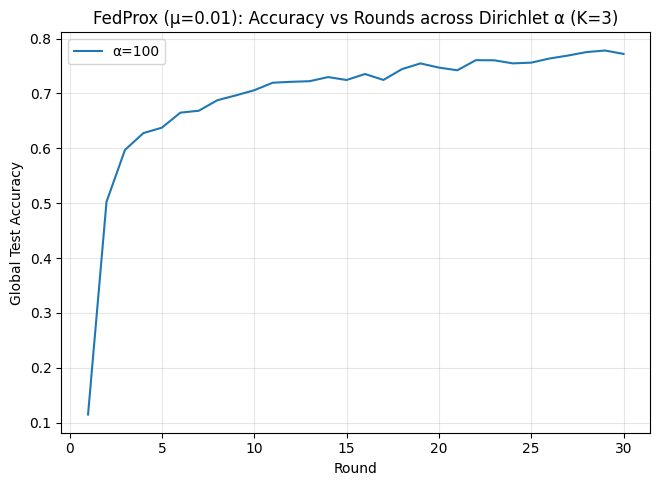

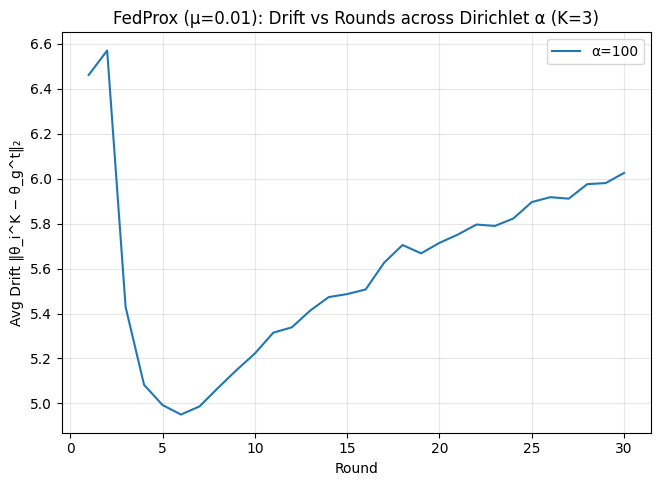

Saved α-sweep figures to:
 - /content/drive/MyDrive/ATML_PA4_Task1_FedSGD/task4_1_fedprox/fedprox_alpha_sweep_acc_mu0.01_K3.png
 - /content/drive/MyDrive/ATML_PA4_Task1_FedSGD/task4_1_fedprox/fedprox_alpha_sweep_drift_mu0.01_K3.png


In [20]:
# ========================
# Run Task 4.1 experiments
# ========================
# A) FedProx across α (fixed µ)
results_alpha = run_task41_fedprox_alpha_sweep(
    alphas=(100,),  # IID → highly skewed
    K=3, rounds=30,
    lr=0.05, momentum=0.9, weight_decay=5e-4,
    mu=0.01,     # fixed µ for α-sweep
    seeds=(0,),  # add more seeds later if needed
    partition_seed=123, batch_size=64
)


[FedProx α-sweep] Building Dirichlet split α=0.01 (seed=777)
[α=0.01] Saved per-client class distribution to:
 - /content/drive/MyDrive/ATML_PA4_Task1_FedSGD/task4_1_fedprox/alpha_0.01_mu_0.01/class_distribution_alpha_0.01.csv
 - /content/drive/MyDrive/ATML_PA4_Task1_FedSGD/task4_1_fedprox/alpha_0.01_mu_0.01/class_distribution_alpha_0.01.json


,client,total,class_0,pct_0,class_1,pct_1,class_2,pct_2,class_3,pct_3,...,class_5,pct_5,class_6,pct_6,class_7,pct_7,class_8,pct_8,class_9,pct_9
0,0,10,1,0.100000,7,0.70000,0,0.00000,1,0.100000,...,0,0.00000,0,0.00000,0,0.000000,0,0.00000,0,0.0000
1,1,5002,0,0.000000,0,0.00000,1,0.00020,0,0.000000,...,1,0.00020,4999,0.99940,0,0.000000,1,0.00020,0,0.0000
2,2,12301,0,0.000000,0,0.00000,4999,0.40639,2302,0.187139,...,4999,0.40639,0,0.00000,1,0.000081,0,0.00000,0,0.0000
3,3,19992,0,0.000000,4993,0.24975,0,0.00000,0,0.000000,...,0,0.00000,1,0.00005,0,0.000000,4999,0.25005,5000,0.2501
4,4,12695,4999,0.393777,0,0.00000,0,0.00000,2697,0.212446,...,0,0.00000,0,0.00000,4999,0.393777,0,0.00000,0,0.0000


[fedprox_alpha_0.01_K3_mu0.01] seed=0 round=01  acc=0.1785  drift=16.70  mu=0.01
[fedprox_alpha_0.01_K3_mu0.01] seed=0 round=02  acc=0.3126  drift=3.51  mu=0.01
[fedprox_alpha_0.01_K3_mu0.01] seed=0 round=03  acc=0.3459  drift=3.40  mu=0.01
[fedprox_alpha_0.01_K3_mu0.01] seed=0 round=04  acc=0.3439  drift=3.30  mu=0.01
[fedprox_alpha_0.01_K3_mu0.01] seed=0 round=05  acc=0.3627  drift=3.21  mu=0.01
[fedprox_alpha_0.01_K3_mu0.01] seed=0 round=06  acc=0.4018  drift=3.13  mu=0.01
[fedprox_alpha_0.01_K3_mu0.01] seed=0 round=07  acc=0.4136  drift=3.07  mu=0.01
[fedprox_alpha_0.01_K3_mu0.01] seed=0 round=08  acc=0.3997  drift=3.03  mu=0.01
[fedprox_alpha_0.01_K3_mu0.01] seed=0 round=09  acc=0.4395  drift=3.02  mu=0.01
[fedprox_alpha_0.01_K3_mu0.01] seed=0 round=10  acc=0.4760  drift=3.01  mu=0.01
[fedprox_alpha_0.01_K3_mu0.01] seed=0 round=11  acc=0.4335  drift=3.04  mu=0.01
[fedprox_alpha_0.01_K3_mu0.01] seed=0 round=12  acc=0.4517  drift=3.06  mu=0.01
[fedprox_alpha_0.01_K3_mu0.01] seed=0 r

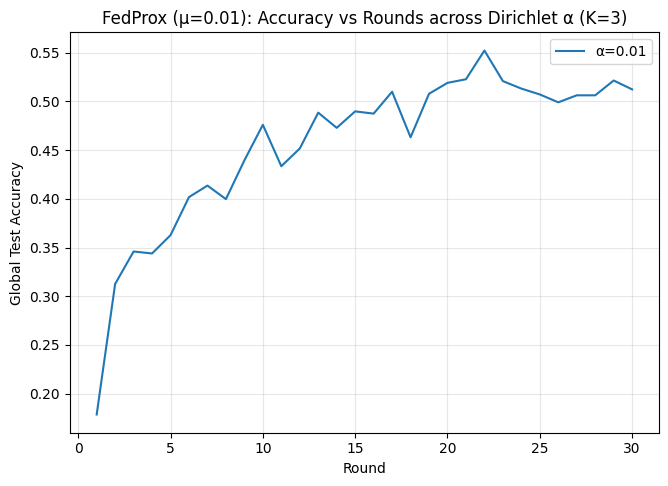

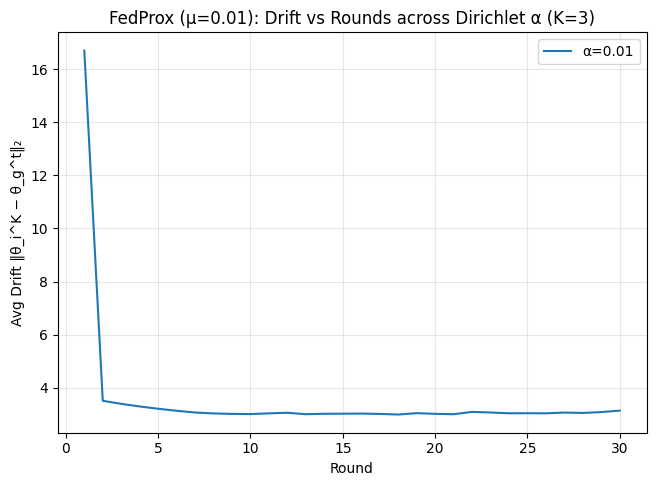

Saved α-sweep figures to:
 - /content/drive/MyDrive/ATML_PA4_Task1_FedSGD/task4_1_fedprox/fedprox_alpha_sweep_acc_mu0.01_K3.png
 - /content/drive/MyDrive/ATML_PA4_Task1_FedSGD/task4_1_fedprox/fedprox_alpha_sweep_drift_mu0.01_K3.png


In [18]:
# ========================
# Run Task 4.1 experiments
# ========================
# A) FedProx across α (fixed µ)
results_alpha = run_task41_fedprox_alpha_sweep(
    alphas=(0.01,),  # IID → highly skewed
    K=3, rounds=30,
    lr=0.05, momentum=0.9, weight_decay=5e-4,
    mu=0.01,     # fixed µ for α-sweep
    seeds=(0,),  # add more seeds later if needed
    partition_seed=777, batch_size=64
)


[FedProx µ-sweep] Building Dirichlet split α=0.2 (seed=123)
[α=0.2] Saved per-client class distribution to:
 - /content/drive/MyDrive/ATML_PA4_Task1_FedSGD/task4_1_fedprox/mu_sweep_alpha_0.2/class_distribution_alpha_0.2.csv
 - /content/drive/MyDrive/ATML_PA4_Task1_FedSGD/task4_1_fedprox/mu_sweep_alpha_0.2/class_distribution_alpha_0.2.json


,client,total,class_0,pct_0,class_1,pct_1,class_2,pct_2,class_3,pct_3,...,class_5,pct_5,class_6,pct_6,class_7,pct_7,class_8,pct_8,class_9,pct_9
0,0,18749,2521,0.134461,549,0.029282,2,0.000107,2293,0.122300,...,3015,0.160809,4639,0.247427,1269,0.067684,144,0.007680,0,0.000000
1,1,7304,400,0.054765,0,0.000000,76,0.010405,2272,0.311062,...,303,0.041484,33,0.004518,3,0.000411,2933,0.401561,960,0.131435
2,2,4667,1992,0.426827,0,0.000000,405,0.086780,1,0.000214,...,1,0.000214,1,0.000214,80,0.017142,1418,0.303835,761,0.163060
3,3,7960,2,0.000251,771,0.096859,2029,0.254899,0,0.000000,...,0,0.000000,325,0.040829,3104,0.389950,309,0.038819,1086,0.136432
4,4,11320,85,0.007509,3680,0.325088,2488,0.219788,434,0.038339,...,1681,0.148498,2,0.000177,544,0.048057,196,0.017314,2193,0.193728


[fedprox_mu_0.005_alpha_0.2_K3] seed=0 round=01  acc=0.1619  drift=9.16  mu=0.005
[fedprox_mu_0.005_alpha_0.2_K3] seed=0 round=02  acc=0.4764  drift=6.88  mu=0.005
[fedprox_mu_0.005_alpha_0.2_K3] seed=0 round=03  acc=0.5606  drift=6.15  mu=0.005
[fedprox_mu_0.005_alpha_0.2_K3] seed=0 round=04  acc=0.5921  drift=5.93  mu=0.005
[fedprox_mu_0.005_alpha_0.2_K3] seed=0 round=05  acc=0.6194  drift=5.81  mu=0.005
[fedprox_mu_0.005_alpha_0.2_K3] seed=0 round=06  acc=0.6674  drift=5.79  mu=0.005
[fedprox_mu_0.005_alpha_0.2_K3] seed=0 round=07  acc=0.6553  drift=5.81  mu=0.005
[fedprox_mu_0.005_alpha_0.2_K3] seed=0 round=08  acc=0.6729  drift=5.74  mu=0.005
[fedprox_mu_0.005_alpha_0.2_K3] seed=0 round=09  acc=0.6967  drift=5.75  mu=0.005
[fedprox_mu_0.005_alpha_0.2_K3] seed=0 round=10  acc=0.6937  drift=5.82  mu=0.005
[fedprox_mu_0.005_alpha_0.2_K3] seed=0 round=11  acc=0.7007  drift=5.84  mu=0.005
[fedprox_mu_0.005_alpha_0.2_K3] seed=0 round=12  acc=0.7059  drift=5.92  mu=0.005
[fedprox_mu_0.00

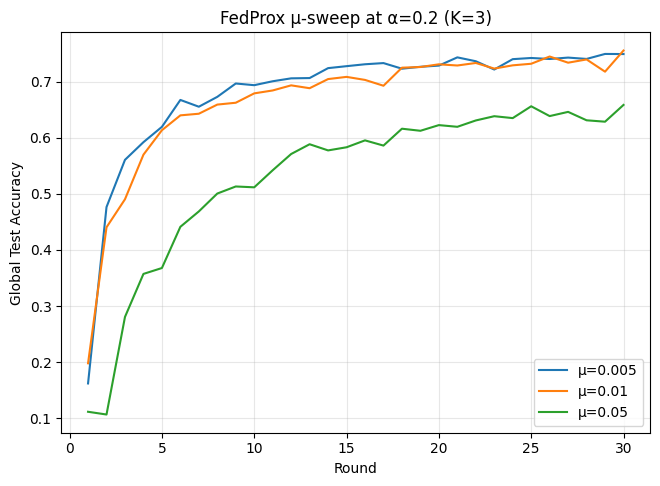

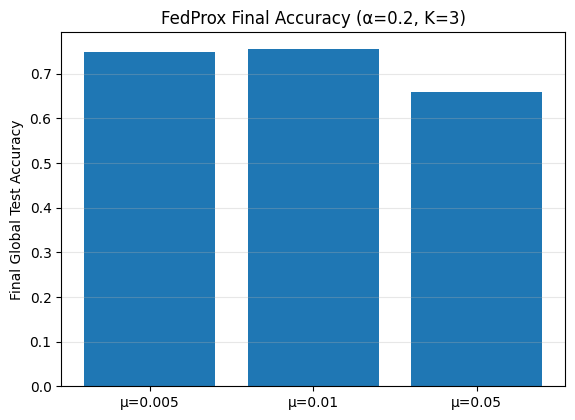

Saved µ-sweep figures to:
 - /content/drive/MyDrive/ATML_PA4_Task1_FedSGD/task4_1_fedprox/mu_sweep_alpha_0.2/fedprox_mu_sweep_acc_alpha_0.2_K3.png
 - /content/drive/MyDrive/ATML_PA4_Task1_FedSGD/task4_1_fedprox/mu_sweep_alpha_0.2/fedprox_mu_sweep_final_acc_alpha_0.2_K3.png


In [21]:
# B) µ sensitivity at α=0.2
results_mu = run_task41_mu_sweep(
    alpha_fixed=0.2,
    mus=(0.005, 0.01, 0.05),
    K=3, rounds=30,
    lr=0.05, momentum=0.9, weight_decay=5e-4,
    seeds=(0,),
    partition_seed=123, batch_size=64
)